# Credit card fraud prediction in financial payment services

## Introduction

Intro to credit card fraud levels increasing. Industry metrics, etc. Add here

## Getting familiar with the data

The tricky part about transactional data is that due to the private nature of transactions, there aren't any publicly available datasets. Yet transactional data is still needed for continued research into fraud detection. 

The simulated data used here is based on a simulator called PaySim which helps bridge the gap between unavailable public data and the need to continue improving fraud detection systems. PaySim utilizes aggregated real world data taken from a private dataset to generate synthetic transactional data resembling normal transactions.
This real world data is a sample of real transactions extracted from financial logs from a mobile money service implemented in an African country. More information about the data can be found here: https://www.kaggle.com/ealaxi/paysim1 

The main challenge the dataset poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data.


### Dataset Description

1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Our goal

Most companies have a fraud loss rate of: ___
We aim to generate a model that falls within this range. We want to be able to better predict and label fraud transactions when they occur. 
Other metrics we can use to evaluate our model __

Include info from web on metrics

### Data Wrangling

In [1]:
# We can start by importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics

In [2]:
# This gives us a first look at the data
df = pd.read_csv('fraud_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# We can start by checking for any null values
# We can see that there are no null values!

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
# A few of the columns we can look at in detail are amount, old and new origin balance, old and new destination balance 

df[['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [5]:
# We can also verify the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## EDA (Exploratory Data Analysis)

We can first get a look of a breakdown of our transactions by type

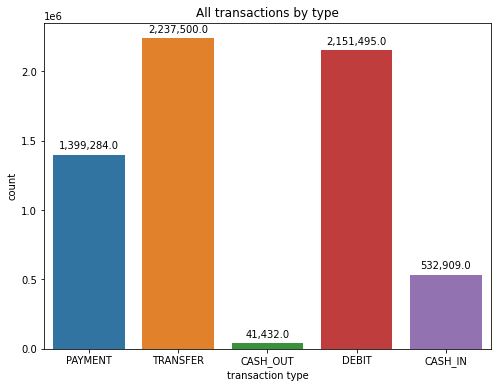

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = df.type.unique(), y = df.groupby('type')['type'].value_counts())
plt.ylabel('count')
plt.xlabel('transaction type')
plt.title('All transactions by type')
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Of all the transactions above, we can get a better look into the fraudulent ones

Text(0.5, 1.0, 'Confusion matrix for simulator results')

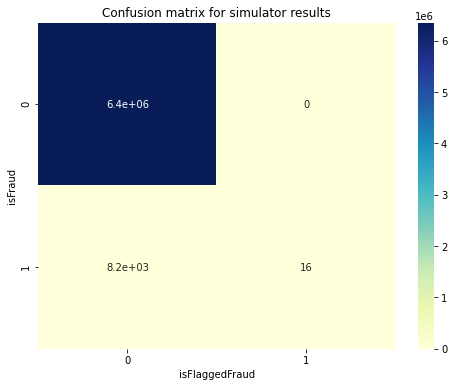

In [7]:
y_true = list(df['isFraud'])
y_pred = list(df['isFlaggedFraud'])
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("isFlaggedFraud")
plt.ylabel("isFraud")
plt.title("Confusion matrix for simulator results")

In [8]:
# Our data contains 8213 fradulent transactions
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

We see that out of over 6 million transactions, only 16 transactions were actually flagged as fraud, and over 8200 were fradulent transactions! The fraud detection system in place is not performing very well. 

Additionally, we see that the fraud transactions are only occuring in either TRANSFER or CASH_OUT types.

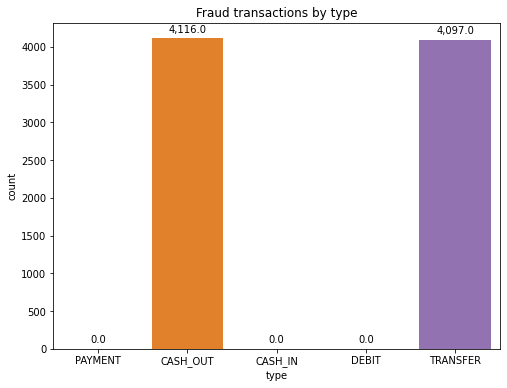

In [103]:
transaction_types = ['PAYMENT', 'CASH_OUT', 'CASH_IN', 'DEBIT', 'TRANSFER']

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x= transaction_types, y=df.groupby('type')['isFraud'].sum())
plt.title('Fraud transactions by type')
plt.xlabel('type')
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [10]:
flagged = df[df['isFlaggedFraud'] == 1]
unflagged = df[df['isFlaggedFraud'] == 0]
fraud = df[df['isFraud'] == 1]

In [11]:
flagged

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


 Additionally,'isFlaggedFraud' is not related to customers who transact more than once where 'isFlagedFraud' is set.
 We obtain a list of names where there was more than 1 fraud transaction

In [12]:
names = []
multiple_flagged = []

for i in fraud['nameDest'].value_counts().index:
    if fraud['nameDest'].value_counts()[i] > 1:
        names.append(i)
    if i in flagged['nameDest']:
        multiple_flagged.append(i)

In [13]:
# We see that none of the addresses that had multiple fraud transactions were flagged as fraud
print('Addresses with multiple fraud transactions that were flagged: {}'.format(len(multiple_flagged)))

print('Number of addresses with multiple fraud transactions: {}'.format(len(names)))

Addresses with multiple fraud transactions that were flagged: 0
Number of addresses with multiple fraud transactions: 44


After looking at these, we can make the decision to drop the 'isFlaggedFraud' column, for several reasons.

    1. There are only 16 flagged transactions out of over 6 million.
    2. The column does not flag all transfers over 200,000 as fraud, and is not related to transfer type or amount. 
    3. The column is not based on multiple fraud transactions.

In [14]:
df = df.drop(labels='isFlaggedFraud', axis=1)

We see from the documentation that there are two categories of destination columns, Merchant and Customer. 
Merchant recepients were not involved in any of the fraud transactions. Additionally, millions of rows of unique labels would be taxing on our computational time. We can drop the nameorigin and namedest columns as well.

In [15]:
df = df.drop(labels=['nameOrig','nameDest'], axis=1)

In [16]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


### Generating a heatmap to identify feature correlations

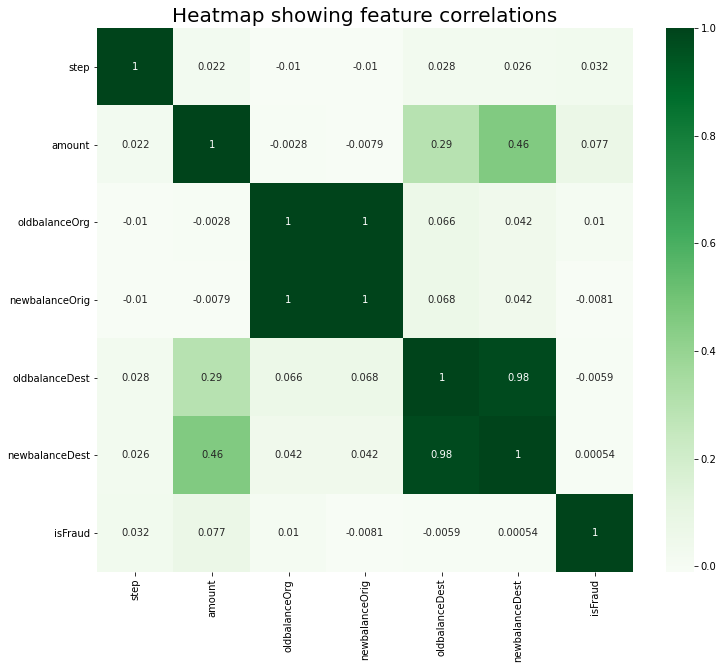

In [17]:
fig, ax = plt.subplots(figsize=(12,10))
_ = sns.heatmap(df.corr(), cmap = 'Greens', annot=True)
_ = plt.title('Heatmap showing feature correlations', fontsize=20)

Looking at the above, we see that 'isFraud' is correlated most to 'amount' (and 'step' a little less so). We look into those below.

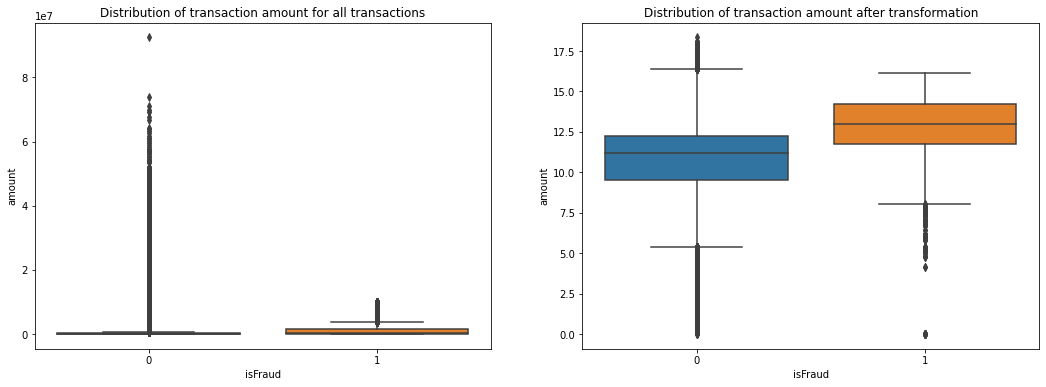

In [18]:
# We first see how the amount transacted is distributed between fraud and nonfraud transactions

# We apply a log transformation to deal with the skewed data

fig, ax = plt.subplots(1,2, figsize=(18,6))
_ = sns.boxplot(x=df.isFraud, y=df.amount, ax=ax[0])
_ = sns.boxplot(x=df.isFraud, y=np.log1p(df.amount), ax=ax[1])
_ = ax[0].title.set_text('Distribution of transaction amount for all transactions')
_ = ax[1].title.set_text('Distribution of transaction amount after transformation')

Since all of our fraud transactions occured in only TRANSFER and CASH_OUT transactions, we can get a better look at those as well.

In [19]:
transfer = df[df['type'] == 'TRANSFER']
cashout = df[df['type'] == 'CASH_OUT']

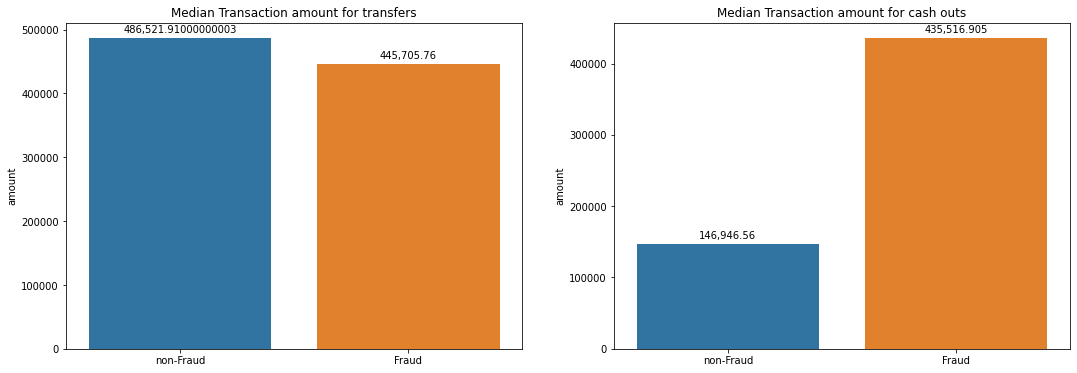

In [20]:
# Here we use median instead of mean to illustrate central tendency in order to suppress the effect of outliers

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].title.set_text("Median Transaction amount for transfers")
ax[1].title.set_text("Median Transaction amount for cash outs")

_ = sns.barplot(x=['non-Fraud', 'Fraud'], y=transfer.groupby('isFraud')['amount'].median(),ax=ax[0])
_ = sns.barplot(x=['non-Fraud', 'Fraud'], y=cashout.groupby('isFraud')['amount'].median(),ax=ax[1])
for i in range(2):
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

The median transaction amount in CASH_OUT transactions is almost 3x higher in fraudulent transactions vs nonfraudulent ones. In transfers, the figure is much closer to even.

#### Visualizing a time series

Another aspect of fraud that we can look into is what part of the day it occurs. We can use 'step' to group the transactions into a per day basis to identify if a pattern is present.

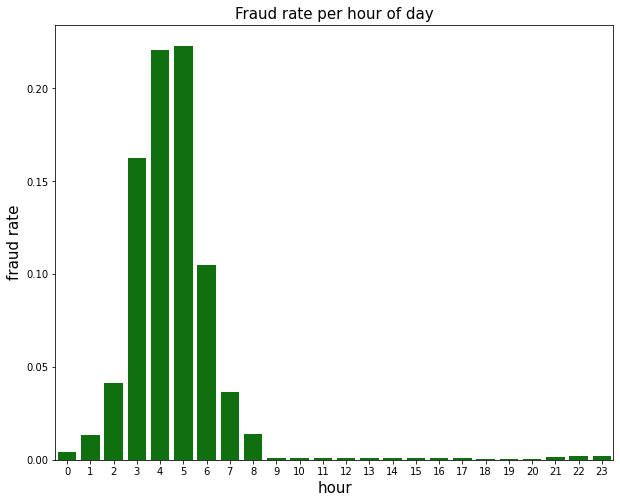

In [21]:
# Here we plot the fradulent transactions on a per hour basis

df['hour'] = df.step % 24
frauds_per_hour = pd.concat([df.groupby("hour")["isFraud"].sum(),df.groupby("hour")["isFraud"].count()],axis=1)
frauds_per_hour.columns = ['num_frauds', 'num_transactions']
frauds_per_hour['fraud_rate'] = frauds_per_hour.num_frauds / frauds_per_hour.num_transactions
_ = plt.subplots(figsize=(10,8))
_ = sns.barplot(x=frauds_per_hour.index, y= frauds_per_hour.fraud_rate, color='green')
_ = plt.title('Fraud rate per hour of day', fontsize=15)
_ = plt.xlabel('hour', fontsize=15)
_ = plt.ylabel('fraud rate', fontsize=15)

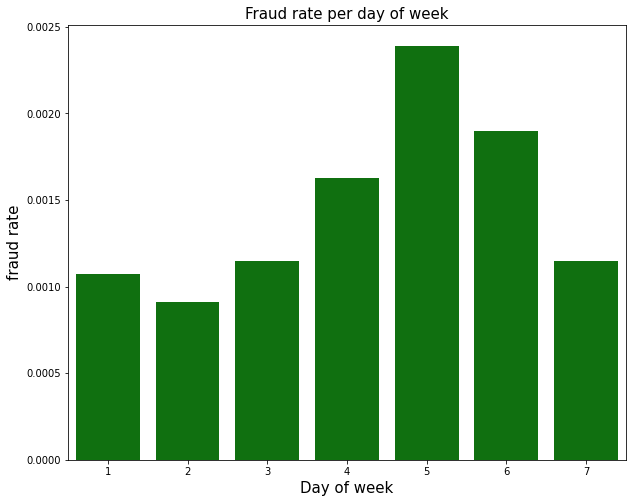

In [93]:
# We can also apply the same concept to visualize fraud rate on a weekly basis

df['dayofmonth'] = round(df.step / 24)
df['dayofweek'] = df['dayofmonth'] % 7
frauds_per_day = pd.concat([df.groupby("dayofweek")["isFraud"].sum(),df.groupby("dayofweek")["isFraud"].count()],axis=1)
frauds_per_day.columns = ['num_frauds', 'num_transactions']
frauds_per_day['fraud_rate'] = frauds_per_day.num_frauds / frauds_per_day.num_transactions
_ = plt.subplots(figsize=(10,8))
_ = sns.barplot(x=list(range(1,8)), y= frauds_per_day.fraud_rate, color='green')
_ = plt.title('Fraud rate per day of week', fontsize=15)
_ = plt.xlabel('Day of week', fontsize=15)
_ = plt.ylabel('fraud rate', fontsize=15)

Two main conclusions from our graphs here. Those are that fraud tends to occur in the early hour of the morning, before 9:00 am, and that it also tends to occur towards the end of the week.

## Feature Engineering

In [23]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayofmonth,dayofweek
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,1,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1,0.0,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,1,0.0,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,1,0.0,0.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,1,0.0,0.0


We have several types of features shown in our df now: Datetime features, numerical features, and categorical features. We need to do some work on all of these.

In [24]:
df1 = df.copy()

##### Datetime

The main datetime feature is 'step'. We also created 'hour', 'day', and 'dayofweek'. So this feature has already been addressed. We saw earlier how fraud transaction rates are much higher in the early morning hours and on the later days of the week.

In [92]:
# Those we have already created

df1['hour'] = df1.step % 24
df1['dayofmonth'] = round(df1.step / 24)
df1['dayofweek'] = df1['dayofweek'] % 7


##### Categorical

The main categorical feature we will focus on here is 'type', since the others have been removed during wrangling. 
Here we can generate dummy variables for the 'type' variable.

In [28]:
df1 = pd.get_dummies(df1,columns=["type"])
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayofmonth,dayofweek,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,1,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,1,0.0,0.0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0.0,0.0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,1,0.0,0.0,0,0,0,1,0


Throughout the dataset, we can pick up on several other trends. Especially when it comes to the fraudulent transactions.

For all the fraudulent transactions:

1. We see that they all follow the same pattern: A 'TRANSFER' of a certain amount followed by a "CASH_OUT' for the same amount immediately after.
2. The 'oldbalanceDest'/'newbalanceDest' is updated (the majority of the time) only after the 'CASH_OUT', not the 'TRANSFER'

We can use this information to generate a new feature that would help our model realize this pattern.

In [57]:
# How many of the fraud transactions are coupled

coupled = 0
amount_match = 0
for i in range(len(fraud) -1):
    if (fraud.iloc[i].type == 'TRANSFER') & (fraud.iloc[i+1].type == 'CASH_OUT'):
        coupled += 1
        if fraud.iloc[i].amount == fraud.iloc[i+1].amount:
            amount_match += 1
            
print('coupled transactions: {}'.format(coupled))
print('coupled transactions where amount matches: {}'.format(amount_match))

coupled transactions: 4091
coupled transactions where amount matches: 4075


In [64]:
# Since they are coupled, we can double them to see statistics of our findings

print('Percentage of fraud transactions that are a part of a coupled transaction: {}'.format((2*coupled/len(fraud))*100))
print('Percentage of fraud transactions that are coupled with matching amounts: {}'.format((2*amount_match/len(fraud))*100))

Percentage of fraud transactions that are a part of a coupled transaction: 99.62254961646171
Percentage of fraud transactions that are coupled with matching amounts: 99.23292341409959


In [90]:
# Now we can apply this as a feature to test all transactions

def is_coupled(df):
    df1['coupled'] = 0
    for i in range(len(df) -1):
        if (df1.iloc[i].type_TRANSFER == 1) & (df1.iloc[i+1].type_CASH_OUT == 1):
            df1['coupled'][i] == 1

In [ ]:
df1.apply(is_coupled)

In [ ]:
df1.head(25)

In [97]:
fraud.type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [ ]:
fraud = df1[df1.isFraud == 1]
fraud.head(10)

In [ ]:
df1[df1.amount == 416001.33]

In [ ]:
df1.iloc[724]

### Reducing data size

#### Undersampling methods